# IMPORTS

In [117]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math
import glob
import re
import os
from matplotlib.patches import ConnectionPatch
from pprint import pprint
from sklearn.metrics import average_precision_score
from random import sample

In [118]:
cv2.__version__

'3.4.2'

In [119]:
project_root = '/home/davidboja/PycharmProjects/FER/hpatches-benchmark/python/ISPA'

# GET FOLDER + IMAGE + TRANSFORMATION NAMES

In [120]:
folders = glob.glob(project_root + '/hpatches-sequences-release/*')

In [121]:
folders[:10]

['/home/davidboja/PycharmProjects/FER/hpatches-benchmark/python/ISPA/hpatches-sequences-release/v_fest',
 '/home/davidboja/PycharmProjects/FER/hpatches-benchmark/python/ISPA/hpatches-sequences-release/i_chestnuts',
 '/home/davidboja/PycharmProjects/FER/hpatches-benchmark/python/ISPA/hpatches-sequences-release/i_nijmegen',
 '/home/davidboja/PycharmProjects/FER/hpatches-benchmark/python/ISPA/hpatches-sequences-release/v_calder',
 '/home/davidboja/PycharmProjects/FER/hpatches-benchmark/python/ISPA/hpatches-sequences-release/v_underground',
 '/home/davidboja/PycharmProjects/FER/hpatches-benchmark/python/ISPA/hpatches-sequences-release/v_talent',
 '/home/davidboja/PycharmProjects/FER/hpatches-benchmark/python/ISPA/hpatches-sequences-release/i_crownday',
 '/home/davidboja/PycharmProjects/FER/hpatches-benchmark/python/ISPA/hpatches-sequences-release/v_there',
 '/home/davidboja/PycharmProjects/FER/hpatches-benchmark/python/ISPA/hpatches-sequences-release/i_duda',
 '/home/davidboja/PycharmProje

In [122]:
len(folders)

116

In [123]:
image_names = glob.glob(project_root + '/hpatches-sequences-release/v_london/*.ppm')
image_names = [im.split('/')[-1] for im in image_names]
image_names = sorted(image_names)

In [124]:
image_names

['1.ppm', '2.ppm', '3.ppm', '4.ppm', '5.ppm', '6.ppm']

In [125]:
transformation_names = glob.glob(project_root + '/hpatches-sequences-release/v_london/H*')
transformation_names = [tr.split('/')[-1] for tr in transformation_names]
transformation_names = sorted(transformation_names)

In [126]:
transformation_names

['H_1_2', 'H_1_3', 'H_1_4', 'H_1_5', 'H_1_6']

Potential detector names:
    1. sift
    2. surf
    3. ORB
    
Potential descriptor names:
    1. sift
    2. surf
    3. ORB

In [271]:
all_detectors = {'sift':cv2.xfeatures2d.SIFT_create,
                 'surf':cv2.xfeatures2d.SURF_create,
                 'ORB':cv2.ORB_create,
                 'fast':cv2.FastFeatureDetector_create,
                 'brisk':cv2.BRISK_create,
                 'harris':HarrisMataHarris,
                 'shi_tomasi':ShiTomasi,
                 'kaze':cv2.KAZE_create}

all_descriptors = {'sift':cv2.xfeatures2d.SIFT_create,
                   'surf':cv2.xfeatures2d.SURF_create,
                   'ORB':cv2.ORB_create,
                   'brisk':cv2.BRISK_create,
                   'freak':cv2.xfeatures2d.FREAK_create,
                   'kaze':cv2.KAZE_create}

# IMPLEMENTATIONS

In [182]:
class HarrisMataHarris():
    '''
    Wrapper for the OpenCV implementation of the Harris detector.
    '''
    def __init__(self, blockSize=2, ksize=3, k=0.04, borderType=cv2.BORDER_DEFAULT):
#         self.src = src
        self.blockSize = blockSize
        self.ksize = ksize
        self.k = k
        self.borderType = borderType
        
    def detect(self, img, mask=None):
        '''
        Keypoint detector method. The threshold is set to 0.01.
        The parameter mask is set to keep standardized inputs for the detect method in the openCv implementations.
        '''
        kp = []
        
        if len(img.shape) == 3:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            
        dst = cv2.cornerHarris(img,self.blockSize,self.ksize,self.k)
        indexes = np.where(dst>0.01*dst.max())
        
        for i in range(len(indexes[0])):
              kp.append(cv2.KeyPoint(x=int(indexes[1][i]), y=int(indexes[0][i]), _size=0))
        
        return kp

In [184]:
class ShiTomasi():
    '''
    other parameters are left to the default OpenCv parameters
    '''
    def __init__(self, maxCorners=1000000, qualityLevel=0.01,minDistance=10):
        self.maxCorners = maxCorners
        self.qualityLevel = qualityLevel
        self.minDistance = minDistance

    def detect(self, img, mask=None):
        keypoints = []

        # Already taken care of in the implementation
        # if len(img.shape) == 3:
        #     img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        corners = cv2.goodFeaturesToTrack(img,
                                          self.maxCorners,
                                          self.qualityLevel,
                                          self.minDistance)
        corners = np.int0(corners)
        corners = corners[:,0,:]

        for i in range(corners.shape[0]):
              keypoints.append(cv2.KeyPoint(x=int(corners[i,0]),
                                            y=int(corners[i,1]),
                                            _size=0))

        return keypoints

# CURRENTLY COMPILED KP AND DES ON DISK

In [272]:
if 'kp.npz' in os.listdir(folders[0]):
    file = np.load(folders[0] + '/kp.npz')
    print(file.files)

['harris', 'sift', 'shi_tomasi']


In [273]:
if 'des.npz' in os.listdir(folders[0]):
    file = np.load(folders[0] + '/des.npz')
    print(file.files)

['harris_sift', 'sift_sift', 'shi_tomasi_sift']


# LOAD IMAGES + FIND KP/DES + SAVE npy OF KP/DES

In [257]:
# #code for deleting all des.npz and kp.npz in all folders
# for folder in folders:
#     desss = glob.glob(folder + '/des*')
#     kpppp = glob.glob(folder + '/kp*')
#     for d in desss:
#         os.remove(d)
#     for k in kpppp:
#         os.remove(k)

In [274]:
detector_name = 'kaze'
descriptor_name = 'kaze'

In [275]:
sequence_images = {}
# transformations = {}

for folder in folders:
    folder_name = folder.split('/')[-1]
    print('Working on folder {}'.format(folder_name))
    
    sequence_images[folder_name] = glob.glob(folder + '/*.ppm')
    #transformations[folder_name] = glob.glob(folder + '/H*')
    
    sequence_images[folder_name] = sorted(sequence_images[folder_name])
    #transformations[folder_name] = sorted(transformations[folder_name])

    sequence_images[folder_name] = [cv2.imread(im) for im in sequence_images[folder_name]]
    #transformations[folder_name] = [load_transform(tr) for tr in transformations[folder_name]]
    
    # find keypoints    
    images_ = [ cv2.cvtColor(im ,cv2.COLOR_RGB2GRAY) for im in sequence_images[folder_name]]
    
    
    detector = [ all_detectors[detector_name]() for im in sequence_images[folder_name]]
    descriptor = [ all_descriptors[descriptor_name]() for im in sequence_images[folder_name]]        
    
    kp = []
    des = []
    
    for id1, algorithm in enumerate(zip(detector,descriptor)):
#         if detector_name == 'harris':
            
#             kp_ = []
#             dst = cv2.cornerHarris(images_[id1],2,3,0.04)
#             indexes = np.where(dst>0.01*dst.max())

#             #print(np.array(indexes).T[:10,:])
            
#             for i in range(len(indexes[0])):
#                 kp_.append(cv2.KeyPoint(x=int(indexes[1][i]), y=int(indexes[0][i]), _size=0))
            
#             #for i in range(5):
#             #    print(kp_[i].pt)
#         else:
            
        kp_ = algorithm[0].detect(images_[id1],None)
        
        kp_, des_ = algorithm[1].compute(images_[id1], kp_)
        
#         print('drugi put')
#         for i in range(5):
#                 print(kp_[i].pt)
        
        #kp, des = det.detectAndCompute(images_[id1],None)
        
        kp_np = np.array([(k.pt[0], k.pt[1], k.angle, k.size, k.response) for k in kp_])
        
#         print('treci put')
#         print(kp_np[:5,:])
        
        kp.append(kp_np)
        des.append(des_)
 

    if 'kp.npz' in os.listdir(folder):
        file = np.load(folder + '/kp.npz')
        elements = dict(file)
        elements[detector_name] = kp
        np.savez(folder + '/kp.npz', **elements)
        
    else:
        np.savez(folder + '/kp.npz', **{detector_name:kp})
        
    if 'des.npz' in os.listdir(folder):
        file = np.load(folder + '/des.npz')
        elements = dict(file)
        elements[detector_name + '_' + descriptor_name] = des
        np.savez(folder + '/des.npz', **elements)
        
    else:
        nm = detector_name + '_' + descriptor_name
        np.savez(folder + '/des.npz', **{nm:des})

Working on folder v_fest
Working on folder i_chestnuts
Working on folder i_nijmegen
Working on folder v_calder
Working on folder v_underground
Working on folder v_talent
Working on folder i_crownday
Working on folder v_there
Working on folder i_duda
Working on folder v_posters
Working on folder v_yuri
Working on folder i_objects
Working on folder i_nuts
Working on folder v_blueprint
Working on folder i_pencils
Working on folder i_fruits
Working on folder i_porta
Working on folder v_london
Working on folder v_beyus
Working on folder v_weapons
Working on folder v_graffiti
Working on folder v_azzola
Working on folder v_woman
Working on folder i_leuven
Working on folder v_vitro
Working on folder i_miniature
Working on folder v_bricks
Working on folder v_gardens
Working on folder i_londonbridge
Working on folder v_dirtywall
Working on folder i_dc
Working on folder v_wormhole
Working on folder i_contruction
Working on folder i_boutique
Working on folder i_books
Working on folder v_charing
Wo

# LOAD KP/DES npy AND REMOVE UNCOMMON POINTS

In [276]:
detector_name = 'kaze'
descriptor_name = 'kaze'

In [277]:
def load_transform(tr):
    with open(tr) as file:
        s = file.read()
        nrs = re.split('\n| ',s)[:-1]
        nrs = [nr for nr in nrs if nr != '']
        return np.array(nrs).reshape(3,3).astype(np.float)

In [278]:
transformations = {}

for folder in folders:
    folder_name = folder.split('/')[-1]
    transformations[folder_name] = glob.glob(folder + '/H*')
    transformations[folder_name] = sorted(transformations[folder_name])
    transformations[folder_name] = [load_transform(tr) for tr in transformations[folder_name]]

In [279]:
# VERZIJA KODA KOJA BRISE KEYPOINTOVE SAMO SA REF SLIKE 
for folder in folders:
    folder_name = folder.split('/')[-1]
    print('#########################################')
    print('Working on folder {}'.format(folder_name))

    kp_file = np.load(folder + '/kp.npz')
    kp = kp_file[detector_name]
    kp = list(kp)
    
    des_file = np.load(folder + '/des.npz')
    nm = detector_name + '_' + descriptor_name
    des = des_file[nm]
    des = list(des)
    
    indexes_to_remove = []
        
    # remove keypoints from ref image that do not appear on sequence images

    remove = set()
    kp_ = kp[0].copy()

    for id2, tr in enumerate(transformations[folder_name]):
        points = np.c_[ kp_[:,[0,1]] , np.ones(kp_.shape[0])]
        imaged_points = np.dot(tr, points.T)
        imaged_points_normal = imaged_points/imaged_points[2,:]

        image_size = cv2.imread(folder + '/' + str(id2+2) + '.ppm' )
        image_size = image_size.shape

        x_indexes_out_of_bounds = np.where((imaged_points_normal[0,:] < 0) |
                                           (image_size[1] < imaged_points_normal[0,:]))[0]


        y_indexes_out_of_bounds = np.where((imaged_points_normal[1,:] < 0) |
                                           (image_size[0] < imaged_points_normal[1,:]))[0]


        remove = remove.union(x_indexes_out_of_bounds)
        remove = remove.union(y_indexes_out_of_bounds)

    indexes_to_remove = list(remove)
    
    print('Removed {} keypoints from image {}/1.ppm'.format(len(indexes_to_remove),folder_name))
    print('old size: {}'.format(kp[0].shape))
    kp[0] = np.delete(kp[0], indexes_to_remove, 0)
    print('new size: {}'.format(kp[0].shape))
    
    des[0] = np.delete(des[0], indexes_to_remove, 0)
            
        
    elements = dict(kp_file)
    elements[detector_name] = kp
    np.savez(folder + '/kp.npz', **elements)
    
    elements = dict(des_file)
    elements[nm] = des
    np.savez(folder + '/des.npz', **elements)

#########################################
Working on folder v_fest
Removed 1451 keypoints from image v_fest/1.ppm
old size: (3462, 5)
new size: (2011, 5)
#########################################
Working on folder i_chestnuts
Removed 0 keypoints from image i_chestnuts/1.ppm
old size: (1870, 5)
new size: (1870, 5)
#########################################
Working on folder i_nijmegen
Removed 0 keypoints from image i_nijmegen/1.ppm
old size: (3675, 5)
new size: (3675, 5)
#########################################
Working on folder v_calder
Removed 198 keypoints from image v_calder/1.ppm
old size: (3435, 5)
new size: (3237, 5)
#########################################
Working on folder v_underground
Removed 2688 keypoints from image v_underground/1.ppm
old size: (7108, 5)
new size: (4420, 5)
#########################################
Working on folder v_talent
Removed 307 keypoints from image v_talent/1.ppm
old size: (7288, 5)
new size: (6981, 5)
#########################################
Wo

Removed 0 keypoints from image i_toy/1.ppm
old size: (376, 5)
new size: (376, 5)
#########################################
Working on folder v_apprentices
Removed 1041 keypoints from image v_apprentices/1.ppm
old size: (12682, 5)
new size: (11641, 5)
#########################################
Working on folder v_home
Removed 1002 keypoints from image v_home/1.ppm
old size: (3932, 5)
new size: (2930, 5)
#########################################
Working on folder i_lionday
Removed 0 keypoints from image i_lionday/1.ppm
old size: (581, 5)
new size: (581, 5)
#########################################
Working on folder v_bark
Removed 55 keypoints from image v_bark/1.ppm
old size: (953, 5)
new size: (898, 5)
#########################################
Working on folder v_samples
Removed 273 keypoints from image v_samples/1.ppm
old size: (6025, 5)
new size: (5752, 5)
#########################################
Working on folder v_war
Removed 513 keypoints from image v_war/1.ppm
old size: (5360, 5)


#########################################
Working on folder v_colors
Removed 101 keypoints from image v_colors/1.ppm
old size: (804, 5)
new size: (703, 5)
#########################################
Working on folder i_ktirio
Removed 0 keypoints from image i_ktirio/1.ppm
old size: (1307, 5)
new size: (1307, 5)
#########################################
Working on folder v_wounded
Removed 2026 keypoints from image v_wounded/1.ppm
old size: (3442, 5)
new size: (1416, 5)
#########################################
Working on folder v_tabletop
Removed 2235 keypoints from image v_tabletop/1.ppm
old size: (7149, 5)
new size: (4914, 5)
#########################################
Working on folder v_birdwoman
Removed 286 keypoints from image v_birdwoman/1.ppm
old size: (4705, 5)
new size: (4419, 5)
#########################################
Working on folder v_yard
Removed 1835 keypoints from image v_yard/1.ppm
old size: (2852, 5)
new size: (1017, 5)
#########################################
Working o

# VISUALIZE SEQUENCE IMAGES FOR FOLDER

In [58]:
# folder_name = 'v_london'

# fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(10,10))
# for i, axx in enumerate(ax.ravel()):
#     axx.imshow(sequence_images[folder_name][i])
#     axx.set_title('{}'.format(image_names[i]))
# plt.show()

# VISUALIZE KEYPOINTS FOR GIVEN FOLDER AND ALGORITHM

In [194]:
folder = folders[0].split('/')[-1]#'v_weapons'
detector_name = 'shi_tomasi'

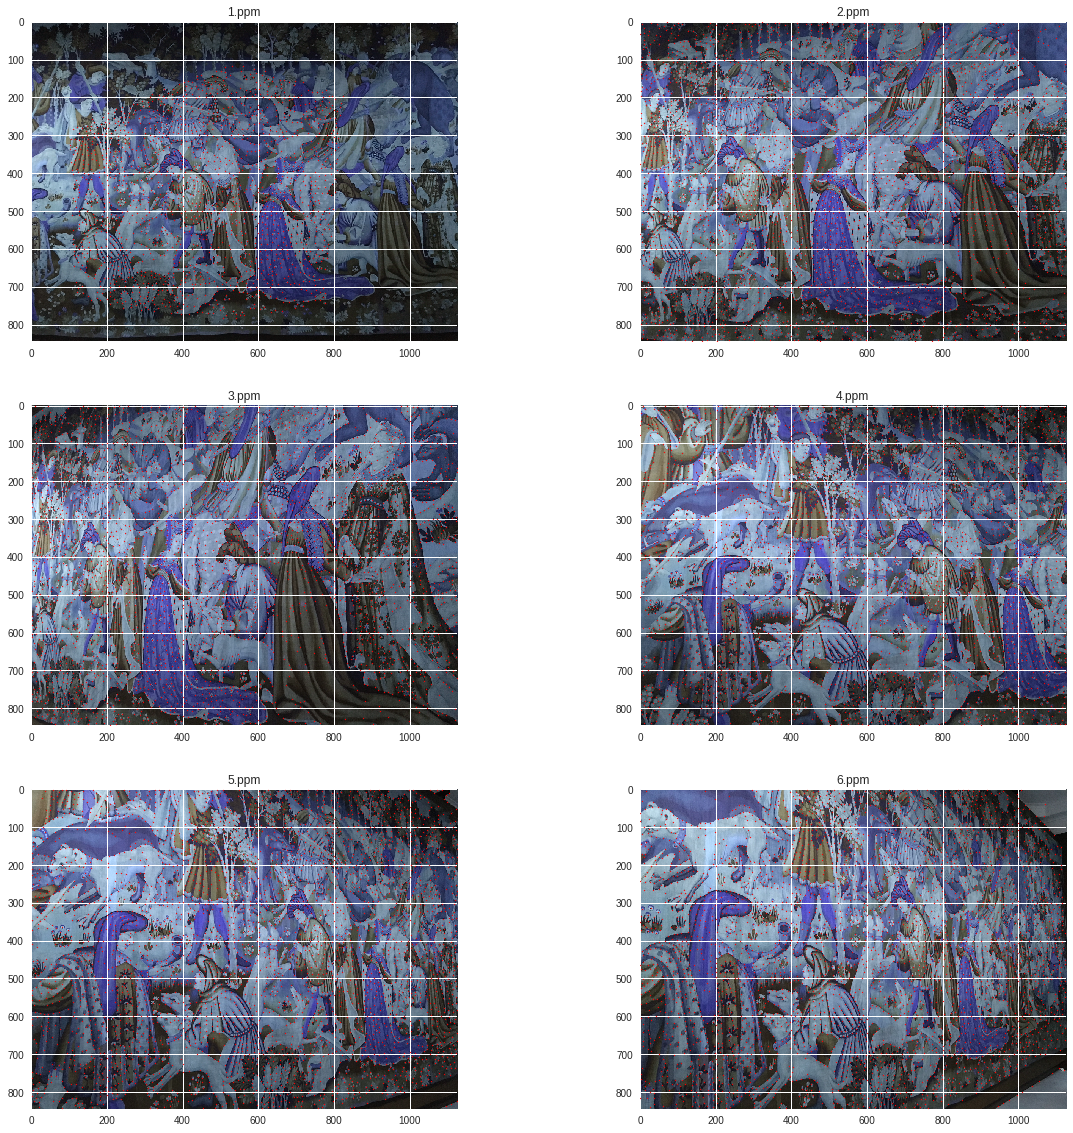

In [205]:
sequence_images = glob.glob(project_root + '/hpatches-sequences-release/' + folder + '/*.ppm')
sequence_images = sorted(sequence_images)
sequence_images = [cv2.imread(im) for im in sequence_images]

kp = np.load(project_root + '/hpatches-sequences-release/' + folder + '/kp.npz')
kp = kp[detector_name]
kp = list(kp)

fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(20,20))
for id1, axx in enumerate(ax.ravel()):
    
    #gray = cv2.cvtColor(sequence_images[id1] ,cv2.COLOR_RGB2GRAY)
#     gray_with_kp = cv2.drawKeypoints(gray, 
#                                      kp[id1], 
#                                      cv2.DRAW_MATCHES_FLAGS_DEFAULT)
    
#     axx.imshow(gray_with_kp)
    
    
    axx.imshow(sequence_images[id1])
    axx.scatter(kp[id1][:,0],kp[id1][:,1], s=1, color='red')
    
    
#     for i in range(kp[id1].shape[0]):
#         sequence_images[id1][int(kp[id1][i,0]),int(kp[id1][i,1])] = [255,0,0]
#     axx.imshow(sequence_images[id1])
    
    axx.set_title('{}'.format(image_names[id1]))
plt.show()

# DRAW TOP TEN MATCHES FOR GIVEN FOLDER AND ALGORITHM

In [206]:
folder = 'v_london'
detector_name = 'shi_tomasi'
descriptor_name = 'sift'

### LOAD  IMG/KP/DES

In [207]:
sequence_images = glob.glob(project_root + '/hpatches-sequences-release/' + folder + '/*.ppm')
sequence_images = sorted(sequence_images)
sequence_images = [cv2.imread(im) for im in sequence_images]

# kp_names = glob.glob(project_root + '/hpatches-sequences-release/' + folder + '/kp_' + detector_name + '*')
# kp_names = sorted(kp_names)
# kp = [np.load(k) for k in kp_names]

# des_names = glob.glob(project_root + '/hpatches-sequences-release/' + folder + '/des_' + descriptor_name + '*')
# des_names = sorted(des_names)
# des = [np.load(d) for d in des_names]

kp = np.load(project_root + '/hpatches-sequences-release/' + folder + '/kp.npz')
kp = kp[detector_name]

des = np.load(project_root + '/hpatches-sequences-release/' + folder + '/des.npz')
nm = detector_name + '_' + descriptor_name
des = des[nm]

In [208]:
print(len(sequence_images))
print(len(kp))
print(len(des))

6
6
6


### COMPUTE MATCHES

In [209]:
matches_with_ref = []

In [210]:
for dess in des[1:]:
    bf = cv2.BFMatcher(cv2.NORM_L2)#, crossCheck=True)
    matches = bf.match(des[0], dess)
    matches_with_ref.append(sorted(matches, key = lambda x:x.distance))

In [211]:
len(matches_with_ref)

5

### VISUALIZE TOP TEN MATCHES FOR SEQUENCE

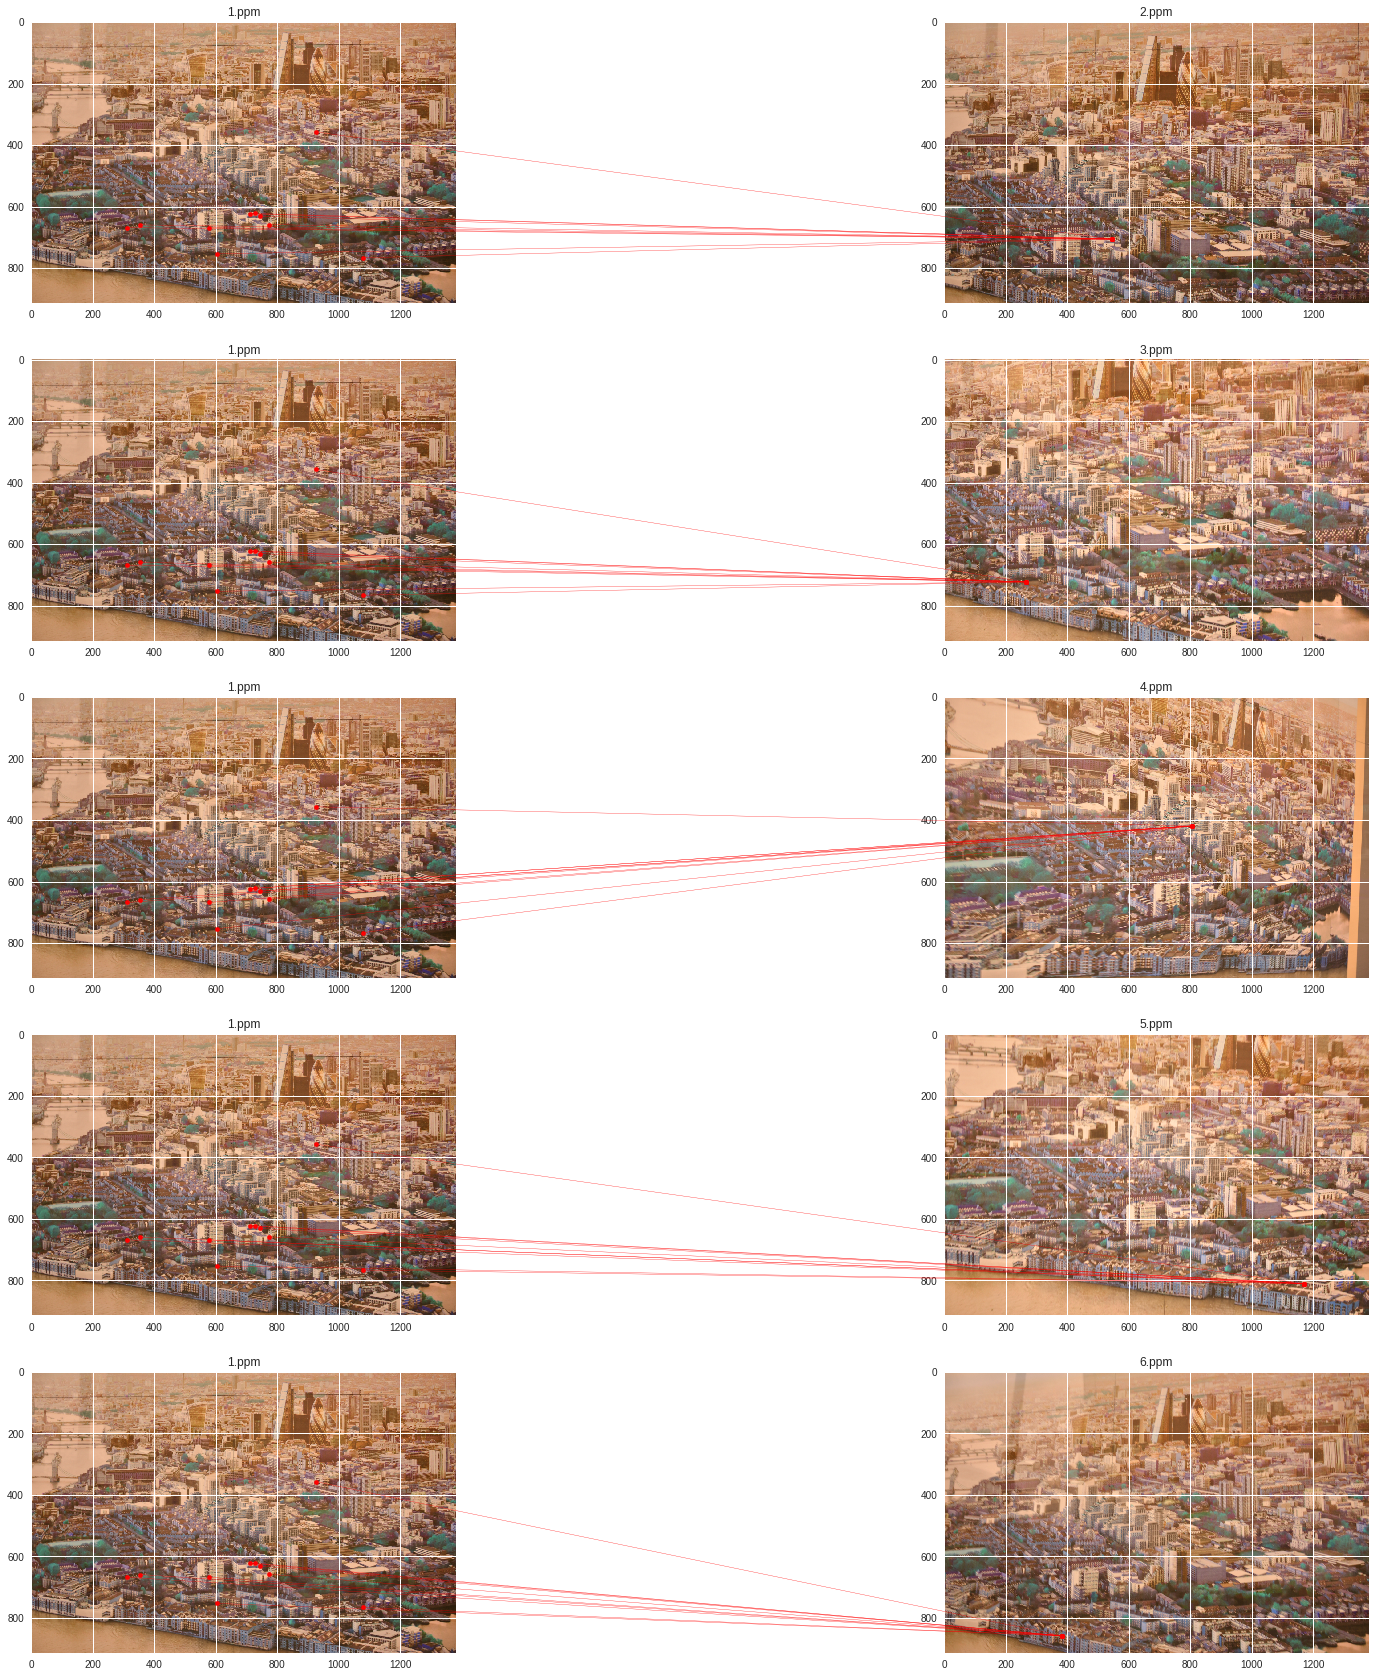

In [212]:
fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(30,30))
for i, axx in enumerate(ax.ravel()):
    if (i % 2) == 1:
        continue
        
    points_on_first_img = []
    points_on_second_img = []
    
    axx.imshow(sequence_images[0])
    axx.set_title('{}'.format(image_names[0]))
    ax.ravel()[i+1].imshow(sequence_images[int(i/2)+1])
    ax.ravel()[i+1].set_title('{}'.format(image_names[int(i/2)+1]))
    
    for m in matches_with_ref[int(i/2)][:10]:
        points_on_first_img.append(kp[0][m.queryIdx,[0,1]])
        points_on_second_img.append(kp[int(i/2)+1][m.trainIdx,[0,1]])
        
    axx.scatter([i[0] for i in points_on_first_img],
                [i[1] for i in points_on_first_img],
                s=20, 
                c='red')
    
    ax.ravel()[i+1].scatter([i[0] for i in points_on_second_img],
                            [i[1] for i in points_on_second_img],
                            s=20, 
                            c='red')
    
    for j in range(len(points_on_first_img)):
        con = ConnectionPatch(xyA=(points_on_second_img[j][0],points_on_second_img[j][1]), 
                              xyB=(points_on_first_img[j][0],points_on_first_img[j][1]),
                              coordsA="data", coordsB="data",
                              axesA=ax.ravel()[i+1], axesB=axx, color="red")
        
        ax.ravel()[i+1].add_artist(con)
    

plt.show()

# EVALUATION

# TASK 1: PATCH VERIFICATION

In [213]:
n = 100

In [214]:
detector_name = 'shi_tomasi'
descriptor_name = 'sift'

In [215]:
def load_transform(tr):
    with open(tr) as file:
        s = file.read()
        nrs = re.split('\n| ',s)[:-1]
        nrs = [nr for nr in nrs if nr != '']
        return np.array(nrs).reshape(3,3).astype(np.float)

In [216]:
transformations = {}

for folder in folders:
    folder_name = folder.split('/')[-1]
    transformations[folder_name] = glob.glob(folder + '/H*')
    transformations[folder_name] = sorted(transformations[folder_name])
    transformations[folder_name] = [load_transform(tr) for tr in transformations[folder_name]]

In [217]:
# c = np.array([[1,2,3],[4,5,6],[7,8,9],[11,12,13]])
# a = np.array([[1,2,3],[4,5,6],[7,8,9]])
# b = np.array([[11,5,4],[5,8,9],[1,3,7]])

In [218]:
y = []
s = []

for id1, folder in enumerate(folders):
    
    folder_name = folder.split('/')[-1]

    # get keypoints from sequence in folder
    kp = np.load(folder + '/kp.npz')
    kp = kp[detector_name]
    kp = list(kp)
    print([kp_.shape for kp_ in kp])
    
    # get descriptors from sequence in folder
    des = np.load(folder + '/des.npz')
    nm = detector_name + '_' + descriptor_name
    des = des[nm]
    des = list(des)

    # get keypoints from next folder
    if id1 != (len(folders)-1):
        next_folder = folders[id1+1]
    else:
        next_folder = folders[0]
        
    print('Working on folder {} --> next_folder {}'.format(folder_name,next_folder.split('/')[-1]))

    kp_next = np.load(next_folder + '/kp.npz')
    kp_next = kp_next[detector_name]
    kp_next = list(kp_next)
    
    des_next = np.load(next_folder + '/des.npz')
    nm = detector_name + '_' + descriptor_name
    des_next = des_next[nm]
    des_next = list(des_next)
    
    # check if an image has no keypoints and skip that evaluating sequence  
    if 0 == kp[0].shape[0]:
        print('Folder {} has 0 keypoints for ref image'.format(folder))
        print('SKIPPING THIS FOLDER')
        continue
    
    # random keypoints from ref image
    nr_of_indexes = min(n,kp[0].shape[0])
    random_keypoint_indexes = sample(range(kp[0].shape[0]), nr_of_indexes)
    # print(random_keypoint_indexes)
    
    # choose ref image
    x_kp = kp[0][random_keypoint_indexes,:]
    x_des = des[0][random_keypoint_indexes,:]
    
    
    for id1, dess in enumerate(des[1:]):
        
        #random_keypoint_indexes_crtano = sample(range(dess.shape[0]), n)
        
        bf = cv2.BFMatcher(cv2.NORM_L2)
        matches = bf.match(x_des, 
                           dess)#[random_keypoint_indexes_crtano,:])
        
        x_idx = [random_keypoint_indexes[m.queryIdx] for m in matches]
        x_crtano_idx = [m.trainIdx for m in matches]
        
        s += [m.distance for m in matches]
        
        # image every keypoint on ref image on 
        # ovdje su Hx spremljeni u stupce, 3xn matrica (treci redak su jedinice)
        tr = transformations[folder_name][id1]
        points = np.c_[ kp[0][x_idx,:][:,[0,1]] , np.ones(len(x_idx))]
        imaged_points = np.dot(tr, points.T)
        imaged_points_normal = imaged_points/imaged_points[2,:]
        
        # compute distance from Hx and x'
        dist = kp[id1+1][x_crtano_idx,:][:,[0,1]].T - imaged_points_normal[[0,1],:]
        distances = np.sqrt(np.sum((dist)**2,axis=0))
        
        # find if x' is the closest keypoint to Hx and assign y
        for i in range(imaged_points_normal.shape[1]):
            # dist_ is the distance from point Hx and every keypoint of image id1+1
            diff = kp[id1+1][:,[0,1]].T - imaged_points_normal[[0,1],i].reshape(2,1)
            dist_ = np.sqrt(np.sum((diff)**2,axis=0))
            if (dist_ < distances[i]).any():
                y.append(-1)
            else:
                y.append(1)  
    
    for id2, dess in enumerate(des_next[1:]):
        bf = cv2.BFMatcher(cv2.NORM_L2)
        matches = bf.match(x_des, 
                           dess)#[random_keypoint_indexes_crtano,:])
        
        s += [m.distance for m in matches]
        y += [-1 for m in matches]

[(1759, 5), (3805, 5), (3493, 5), (3892, 5), (3841, 5), (3695, 5)]
Working on folder v_fest --> next_folder i_chestnuts
[(638, 5), (772, 5), (783, 5), (754, 5), (636, 5), (582, 5)]
Working on folder i_chestnuts --> next_folder i_nijmegen
[(3601, 5), (2872, 5), (3675, 5), (1547, 5), (3087, 5), (2857, 5)]
Working on folder i_nijmegen --> next_folder v_calder
[(2082, 5), (1778, 5), (2368, 5), (1114, 5), (1541, 5), (1068, 5)]
Working on folder v_calder --> next_folder v_underground
[(1538, 5), (2089, 5), (1833, 5), (1937, 5), (1563, 5), (2753, 5)]
Working on folder v_underground --> next_folder v_talent
[(2839, 5), (2412, 5), (2344, 5), (2745, 5), (2237, 5), (2194, 5)]
Working on folder v_talent --> next_folder i_crownday
[(2272, 5), (2314, 5), (2207, 5), (2189, 5), (2596, 5), (1800, 5)]
Working on folder i_crownday --> next_folder v_there
[(8722, 5), (4808, 5), (3959, 5), (3092, 5), (2761, 5), (2249, 5)]
Working on folder v_there --> next_folder i_duda
[(748, 5), (716, 5), (638, 5), (557,

[(2387, 5), (2979, 5), (3570, 5), (3510, 5), (3612, 5), (3859, 5)]
Working on folder i_indiana --> next_folder v_bees
[(3475, 5), (4016, 5), (4285, 5), (3342, 5), (2277, 5), (2193, 5)]
Working on folder v_bees --> next_folder i_brooklyn
[(2225, 5), (2628, 5), (1914, 5), (2278, 5), (1956, 5), (2462, 5)]
Working on folder i_brooklyn --> next_folder i_greentea
[(837, 5), (732, 5), (961, 5), (924, 5), (864, 5), (681, 5)]
Working on folder i_greentea --> next_folder v_coffeehouse
[(820, 5), (2127, 5), (2082, 5), (1208, 5), (2569, 5), (1756, 5)]
Working on folder v_coffeehouse --> next_folder i_castle
[(881, 5), (895, 5), (745, 5), (582, 5), (449, 5), (628, 5)]
Working on folder i_castle --> next_folder i_fog
[(1149, 5), (1066, 5), (852, 5), (1275, 5), (796, 5), (699, 5)]
Working on folder i_fog --> next_folder i_dome
[(1754, 5), (1036, 5), (2547, 5), (2596, 5), (2648, 5), (3234, 5)]
Working on folder i_dome --> next_folder v_wall
[(1862, 5), (1947, 5), (758, 5), (1330, 5), (1615, 5), (884, 

In [219]:
s[:10]

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [220]:
s2 = [-s_ for s_ in s]

In [221]:
y[:10]

[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1]

In [222]:
print(y.count(1))
print(y.count(-1))

91
115909


Trebalo bi biti n * 10 * broj_foldera <br> (AKO UZIMA n TOCAKA)

In [223]:
n*10*len(folders) == len(y)

True

Potencijalnih matcheva je n * 5 * broj_foldera

In [224]:
n * 5 * len(folders)

58000

In [225]:
AP = average_precision_score(y,s2)
print(AP)

0.0007844827586206897


In [226]:
print('| x | {} | {} | {} | {} | {} | {} | {} |'.format(detector_name,
                                                        descriptor_name,
                                                        AP,
                                                        n,
                                                        y.count(1),
                                                        y.count(-1),
                                                        n*5*len(folders)))

| x | shi_tomasi | sift | 0.0007844827586206897 | 100 | 91 | 115909 | 58000 |


| id | det | des | AP | max n | 1 | -1 | potencijalnih matcheva |
| --- | --- | --- | --- | --- | --- | --- | --- |
| 1 | sift | sift | 0.586862720350904 | 100 | 14914 | 101086 | 58000 |
| 2 | sift | sift | 0.593464318477201 | 100 | 15239 | 100761 | 58000 |
| 3 | sift | sift | 0.6065553783395058 | 100 | 15187 | 100813 | 58000 |
| 4 | sift | sift | 0.5908968401464723 | 100 | 15141 | 100859 | 58000 |
| 5 | sift | sift | 0.6003174809347416 | 100 | 15107 | 100893 | 58000 |
| 6 | surf | surf | 0.3899221777180763 | 100 | 13210 | 102790 | 58000 |
| 7 | ORB | ORB | 0.4301131784419977 | 50 | 3708 | 53212 | 29000 |
| 8 | fast | sift | 0.6984606609463924 | 50 | 11662 | 46338 | 29000 |
| 9 | brisk | brisk | 0.5529112571630087 | 100 | 10430 | 105570 | 58000 |
| 10 | brisk | freak | 0.3873563875490459 | 100 | 10065 | 105695 | 58000 |
| 11 | harris | sift | 0.000854332067656196 | 100 | 99 | 115781 | 58000 |
| 12 | shi_tomasi | sift | 0.0007844827586206897 | 100 | 91 | 115909 | 58000 |





n je max tocaka koji uzimamo jer potencijalno nema toliko tocaka, pa uzmemo manje

| id | det | des | 5_mAP | n | mean 1 | mean -1 | potencijalnih matcheva |
| --- | --- | --- | --- | --- | --- | --- | --- |
| 1 | sift | sift | 0.5956193476497649 | 100 | 15117.6 | 100882.4 | 58000 |

In [50]:
# ranked_list = sorted(range(len(s)), key=lambda k: s[k])

# TASK 2: IMAGE MATCHING

In [258]:
n = 100

In [259]:
detector_name = 'sift'
descriptor_name = 'sift'

In [260]:
def load_transform(tr):
    with open(tr) as file:
        s = file.read()
        nrs = re.split('\n| ',s)[:-1]
        nrs = [nr for nr in nrs if nr != '']
        return np.array(nrs).reshape(3,3).astype(np.float)

In [261]:
transformations = {}

for folder in folders:
    folder_name = folder.split('/')[-1]
    transformations[folder_name] = glob.glob(folder + '/H*')
    transformations[folder_name] = sorted(transformations[folder_name])
    transformations[folder_name] = [load_transform(tr) for tr in transformations[folder_name]]

In [262]:
y = []
s = []

for id1, folder in enumerate(folders):
    
    folder_name = folder.split('/')[-1]
    print('Working on folder {}'.format(folder_name,))

    # get keypoints from sequence in folder
    kp = np.load(folder + '/kp.npz')
    kp = kp[detector_name]
    kp = list(kp)
    
    # get descriptors from sequence in folder
    des = np.load(folder + '/des.npz')
    nm = detector_name + '_' + descriptor_name
    des = des[nm]
    des = list(des)
    
    
    # check if an image has no keypoints and skip that evaluating sequence  
    if 0 == kp[0].shape[0]:
        print('Folder {} has 0 keypoints for ref image'.format(folder))
        print('SKIPPING THIS FOLDER')
        continue
    
    # random keypoints from ref image
    nr_of_indexes = min(n,kp[0].shape[0])
    random_keypoint_indexes = sample(range(kp[0].shape[0]), nr_of_indexes)
    print('NR OF INDEXES: {}'.format(nr_of_indexes))

    
    # choose ref image
    x_kp = kp[0][random_keypoint_indexes,:]
    x_des = des[0][random_keypoint_indexes,:]
    
    
    for id1, dess in enumerate(des[1:]):
        
        bf = cv2.BFMatcher(cv2.NORM_L2)
        matches = bf.match(x_des, 
                           dess)
        
        x_idx = [random_keypoint_indexes[m.queryIdx] for m in matches]
        x_crtano_idx = [m.trainIdx for m in matches]
        
        s += [m.distance for m in matches]
        
        # image every keypoint on ref image on 
        # ovdje su Hx spremljeni u stupce, 3xn matrica (treci redak su jedinice)
        tr = transformations[folder_name][id1]
        points = np.c_[ kp[0][x_idx,:][:,[0,1]] , np.ones(len(x_idx))]
        imaged_points = np.dot(tr, points.T)
        imaged_points_normal = imaged_points/imaged_points[2,:]
        
        # compute distance from Hx and x'
        dist = kp[id1+1][x_crtano_idx,:][:,[0,1]].T - imaged_points_normal[[0,1],:]
        distances = np.sqrt(np.sum((dist)**2,axis=0))
        
        # find if x' is the closest keypoint to Hx and assign y
        for i in range(imaged_points_normal.shape[1]):
            # dist_ is the distance from point Hx and every keypoint of image id1+1
            diff = kp[id1+1][:,[0,1]].T - imaged_points_normal[[0,1],i].reshape(2,1)
            dist_ = np.sqrt(np.sum((diff)**2,axis=0))
            if (dist_ < distances[i]).any():
                y.append(-1)
            else:
                y.append(1)  

Working on folder v_fest
NR OF INDEXES: 100
Working on folder i_chestnuts
NR OF INDEXES: 100
Working on folder i_nijmegen
NR OF INDEXES: 100
Working on folder v_calder
NR OF INDEXES: 100
Working on folder v_underground
NR OF INDEXES: 100
Working on folder v_talent
NR OF INDEXES: 100
Working on folder i_crownday
NR OF INDEXES: 100
Working on folder v_there
NR OF INDEXES: 100
Working on folder i_duda
NR OF INDEXES: 100
Working on folder v_posters
NR OF INDEXES: 100
Working on folder v_yuri
NR OF INDEXES: 100
Working on folder i_objects
NR OF INDEXES: 100
Working on folder i_nuts
NR OF INDEXES: 100
Working on folder v_blueprint
NR OF INDEXES: 100
Working on folder i_pencils
NR OF INDEXES: 100
Working on folder i_fruits
NR OF INDEXES: 100
Working on folder i_porta
NR OF INDEXES: 100
Working on folder v_london
NR OF INDEXES: 100
Working on folder v_beyus
NR OF INDEXES: 100
Working on folder v_weapons
NR OF INDEXES: 100
Working on folder v_graffiti
NR OF INDEXES: 100
Working on folder v_azzo

In [263]:
s[:10]

[195.3023223876953,
 114.38968658447266,
 187.88294982910156,
 153.08494567871094,
 299.4111022949219,
 277.1281433105469,
 245.93495178222656,
 182.86880493164062,
 153.61965942382812,
 112.23635864257812]

In [264]:
s2 = [-s_ for s_ in s]

In [265]:
y[:10]

[-1, -1, 1, 1, -1, -1, 1, -1, 1, 1]

In [266]:
print(y.count(1))
print(y.count(-1))

14779
43221


Trebalo bi biti n * 10 * broj_foldera <br> (AKO UZIMA n TOCAKA)

In [267]:
n*10*len(folders) == len(y)

False

Potencijalnih matcheva je n * 5 * broj_foldera

In [268]:
n * 5 * len(folders)

58000

In [269]:
AP = average_precision_score(y,s2)
print(AP)

0.6603045741933338


In [270]:
print('| x | {} | {} | {} | {} | {} | {} | {} |'.format(detector_name,
                                                        descriptor_name,
                                                        AP,
                                                        n,
                                                        y.count(1),
                                                        y.count(-1),
                                                        n*5*len(folders)))

| x | sift | sift | 0.6603045741933338 | 100 | 14779 | 43221 | 58000 |


| id | det | des | AP | max n | 1 | -1 | potencijalnih matcheva |
| --- | --- | --- | --- | --- | --- | --- | --- |
| 1 | harris | sift | 0.0015360717984121506 | 100 | 89 | 57851 | 58000 |
| x | shi_tomasi | sift | 0.0014655172413793104 | 100 | 85 | 57915 | 58000 |
| x | sift | sift | 0.6603045741933338 | 100 | 14779 | 43221 | 58000 |





n je max tocaka koji uzimamo jer potencijalno nema toliko tocaka, pa uzmemo manje

# TASK 3: PATCH RETRIEVAL

In [240]:
n = 100

In [241]:
detector_name = 'shi_tomasi'
descriptor_name = 'sift'

In [242]:
def load_transform(tr):
    with open(tr) as file:
        s = file.read()
        nrs = re.split('\n| ',s)[:-1]
        nrs = [nr for nr in nrs if nr != '']
        return np.array(nrs).reshape(3,3).astype(np.float)

In [243]:
transformations = {}

for folder in folders:
    folder_name = folder.split('/')[-1]
    transformations[folder_name] = glob.glob(folder + '/H*')
    transformations[folder_name] = sorted(transformations[folder_name])
    transformations[folder_name] = [load_transform(tr) for tr in transformations[folder_name]]

In [244]:
# c = np.array([[1,2,3],[4,5,6],[7,8,9],[11,12,13]])
# a = np.array([[1,2,3],[4,5,6],[7,8,9]])
# b = np.array([[11,5,4],[5,8,9],[1,3,7]])

In [245]:
y = []
s = []

for id1, folder in enumerate(folders):
    
    folder_name = folder.split('/')[-1]

    # get keypoints from sequence in folder
    kp = np.load(folder + '/kp.npz')
    kp = kp[detector_name]
    kp = list(kp)
    print([kp_.shape for kp_ in kp])
    
    # get descriptors from sequence in folder
    des = np.load(folder + '/des.npz')
    nm = detector_name + '_' + descriptor_name
    des = des[nm]
    des = list(des)

    # get keypoints from next folder
    if id1 != (len(folders)-1):
        next_folder = folders[id1+1]
    else:
        next_folder = folders[0]
        
    print('Working on folder {} --> next_folder {}'.format(folder_name,next_folder.split('/')[-1]))

    kp_next = np.load(next_folder + '/kp.npz')
    kp_next = kp_next[detector_name]
    kp_next = list(kp_next)
    
    des_next = np.load(next_folder + '/des.npz')
    nm = detector_name + '_' + descriptor_name
    des_next = des_next[nm]
    des_next = list(des_next)
    
    # check if an image has no keypoints and skip that evaluating sequence  
    if 0 == kp[0].shape[0]:
        print('Folder {} has 0 keypoints for ref image'.format(folder))
        print('SKIPPING THIS FOLDER')
        continue
    
    # random keypoints from ref image
    nr_of_indexes = min(n,kp[0].shape[0])
    random_keypoint_indexes = sample(range(kp[0].shape[0]), nr_of_indexes)
    print('NR OF INDEXES: {}'.format(nr_of_indexes))
    
    # choose ref image
    x_kp = kp[0][random_keypoint_indexes,:]
    x_des = des[0][random_keypoint_indexes,:]
    
    
    for id1, dess in enumerate(des[1:]):
        
        # image every keypoint from ref image onto sequence image
        # ovdje su Hx spremljeni u stupce, 3xn matrica (treci redak su jedinice)
        tr = transformations[folder_name][id1]
        points = np.c_[ x_kp , np.ones(len(x_kp.shape[0]))]
        imaged_points = np.dot(tr, points.T)
        imaged_points_normal = imaged_points/imaged_points[2,:]
        
        # za svaki redak iz Hx matrice pronadji mu najblizi keypoint
        for i in range(imaged_points_normal.shape[1]):
            kp[id1+1][:[0,1]].T - imaged_points_normal[[0,1],:]
        
        
        
        
        
        bf = cv2.BFMatcher(cv2.NORM_L2)
        matches = bf.match(x_des, 
                           dess)
        
        x_idx = [random_keypoint_indexes[m.queryIdx] for m in matches]
        x_crtano_idx = [m.trainIdx for m in matches]
        
        s += [m.distance for m in matches]
        
        # image every keypoint on ref image on 
        # ovdje su Hx spremljeni u stupce, 3xn matrica (treci redak su jedinice)
        tr = transformations[folder_name][id1]
        points = np.c_[ kp[0][x_idx,:][:,[0,1]] , np.ones(len(x_idx))]
        imaged_points = np.dot(tr, points.T)
        imaged_points_normal = imaged_points/imaged_points[2,:]
        
        # compute distance from Hx and x'
        dist = kp[id1+1][x_crtano_idx,:][:,[0,1]].T - imaged_points_normal[[0,1],:]
        distances = np.sqrt(np.sum((dist)**2,axis=0))
        
        # find if x' is the closest keypoint to Hx and assign y
        for i in range(imaged_points_normal.shape[1]):
            # dist_ is the distance from point Hx and every keypoint of image id1+1
            diff = kp[id1+1][:,[0,1]].T - imaged_points_normal[[0,1],i].reshape(2,1)
            dist_ = np.sqrt(np.sum((diff)**2,axis=0))
            if (dist_ < distances[i]).any():
                y.append(-1)
            else:
                y.append(1)  
    
    for id2, dess in enumerate(des_next[1:]):
        bf = cv2.BFMatcher(cv2.NORM_L2)
        matches = bf.match(x_des, 
                           dess)
        
        s += [m.distance for m in matches]
        y += [-1 for m in matches]

[(1759, 5), (3805, 5), (3493, 5), (3892, 5), (3841, 5), (3695, 5)]
Working on folder v_fest --> next_folder i_chestnuts
NR OF INDEXES: 100
[(638, 5), (772, 5), (783, 5), (754, 5), (636, 5), (582, 5)]
Working on folder i_chestnuts --> next_folder i_nijmegen
NR OF INDEXES: 100
[(3601, 5), (2872, 5), (3675, 5), (1547, 5), (3087, 5), (2857, 5)]
Working on folder i_nijmegen --> next_folder v_calder
NR OF INDEXES: 100
[(2082, 5), (1778, 5), (2368, 5), (1114, 5), (1541, 5), (1068, 5)]
Working on folder v_calder --> next_folder v_underground
NR OF INDEXES: 100
[(1538, 5), (2089, 5), (1833, 5), (1937, 5), (1563, 5), (2753, 5)]
Working on folder v_underground --> next_folder v_talent
NR OF INDEXES: 100
[(2839, 5), (2412, 5), (2344, 5), (2745, 5), (2237, 5), (2194, 5)]
Working on folder v_talent --> next_folder i_crownday
NR OF INDEXES: 100
[(2272, 5), (2314, 5), (2207, 5), (2189, 5), (2596, 5), (1800, 5)]
Working on folder i_crownday --> next_folder v_there
NR OF INDEXES: 100
[(8722, 5), (4808, 

[(5443, 5), (5080, 5), (4247, 5), (3640, 5), (3750, 5), (4145, 5)]
Working on folder v_pomegranate --> next_folder i_fenis
NR OF INDEXES: 100
[(666, 5), (704, 5), (711, 5), (641, 5), (433, 5), (394, 5)]
Working on folder i_fenis --> next_folder v_strand
NR OF INDEXES: 100
[(1779, 5), (2170, 5), (1722, 5), (1960, 5), (1425, 5), (1302, 5)]
Working on folder v_strand --> next_folder i_bridger
NR OF INDEXES: 100
[(2478, 5), (2607, 5), (2196, 5), (1292, 5), (669, 5), (132, 5)]
Working on folder i_bridger --> next_folder v_astronautis
NR OF INDEXES: 100
[(1075, 5), (1934, 5), (1868, 5), (1806, 5), (1371, 5), (5729, 5)]
Working on folder v_astronautis --> next_folder i_veggies
NR OF INDEXES: 100
[(955, 5), (960, 5), (923, 5), (937, 5), (814, 5), (780, 5)]
Working on folder i_veggies --> next_folder v_eastsouth
NR OF INDEXES: 100
[(2417, 5), (2435, 5), (2417, 5), (2155, 5), (2300, 5), (1967, 5)]
Working on folder v_eastsouth --> next_folder i_nescafe
NR OF INDEXES: 100
[(419, 5), (447, 5), (57

In [246]:
s[:10]

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [247]:
s2 = [-s_ for s_ in s]

In [248]:
y[:10]

[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1]

In [249]:
print(y.count(1))
print(y.count(-1))

109
115891


Trebalo bi biti n * 10 * broj_foldera <br> (AKO UZIMA n TOCAKA)

In [250]:
n*10*len(folders) == len(y)

True

Potencijalnih matcheva je n * 5 * broj_foldera

In [251]:
n * 5 * len(folders)

58000

In [252]:
AP = average_precision_score(y,s2)
print(AP)

0.0009396551724137931


In [253]:
print('| x | {} | {} | {} | {} | {} | {} | {} |'.format(detector_name,
                                                        descriptor_name,
                                                        AP,
                                                        n,
                                                        y.count(1),
                                                        y.count(-1),
                                                        n*5*len(folders)))

| x | shi_tomasi | sift | 0.0009396551724137931 | 100 | 109 | 115891 | 58000 |


| id | det | des | AP | max n | 1 | -1 | potencijalnih matcheva |
| --- | --- | --- | --- | --- | --- | --- | --- |
| x | shi_tomasi | sift | 0.0009396551724137931 | 100 | 109 | 115891 | 58000 |





n je max tocaka koji uzimamo jer potencijalno nema toliko tocaka, pa uzmemo manje

# DRAW EVALUATION RESULTS

In [18]:
dict_of_mAPs = {'mmaP1': list(np.random.rand(5)),
               'mmaP2' : list(np.random.rand(5)),
               'mmaP3' : list(np.random.rand(5)),
               'mmaP4' : list(np.random.rand(5)),
               'mmaP5' : list(np.random.rand(5)),
               'mmaP6' : list(np.random.rand(5)),
               'mmaP7' : list(np.random.rand(5)),
               'mmaP8' : list(np.random.rand(5))}

In [24]:
names = []
scores = []
err = []

for alg,results in dict_of_APs.items():
        names.append(alg)
        mean_ = np.mean(results)
        scores.append(mean_)
        err.append([mean_ - min(results),max(results)- mean_])

In [22]:
pos = np.arange(len(dict_of_mAPs))

/home/davidboja/anaconda3/envs/Python_environment_david/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


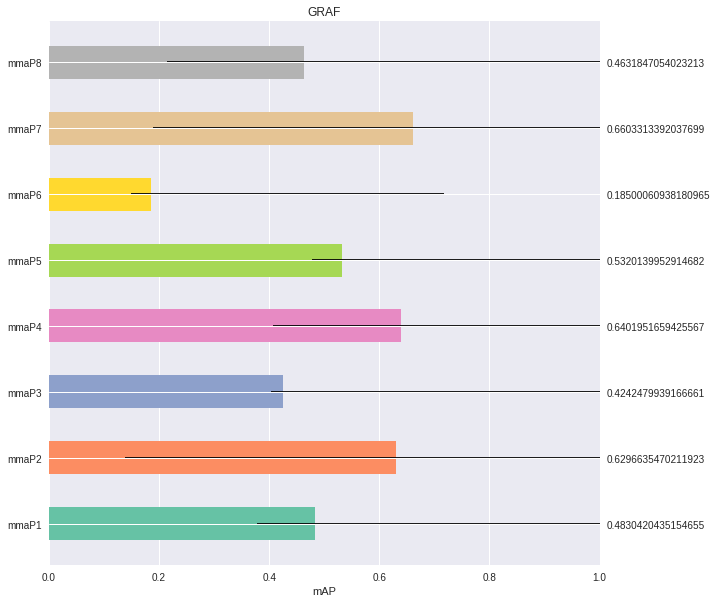

In [31]:
#import seaborn
#plt.style.use('seaborn')

fig, ax1 = plt.subplots(figsize=(10,10))
fig.subplots_adjust(left=0.115, right=0.88)

#ax1.set_style('seaborn')

ax1.barh(pos, scores,
         align='center',
         height=0.5,
         tick_label=names,
         xerr=np.array(err).T,
         color=seaborn.color_palette("Set2"))
plt.xlim([0, 1])
ax1.set_xlabel('mAP')

ax2 = ax1.twinx()
ax2.set_yticks(pos)
ax2.set_ylim(ax1.get_ylim())
ax2.set_yticklabels(scores)

ax1.set_title('GRAF')
fig.show()